### Feature Extraction Code for Camel Dataset

This code is designed to extract features from the videos in the [Camel dataset](https://camel.ece.gatech.edu/). It assumes you already have annotation files in text format with the following structure:

**Annotation Format:**
- Frame Number
- Track ID Number
- Annotation Class
- Bounding Box Top Left X Coordinate
- Bounding Box Top Left Y Coordinate
- Bounding Box Width
- Bounding Box Height

Ensure your annotation files follow this format for accurate feature extraction.


In [ ]:
import cv2
import numpy as np
import pandas as pd
from pathlib import Path

### Setting Dataset Path and Annotation Name


To get started, ensure you set the path to the Camel dataset and set the name of the ground truth files appropriately:

```python
path = "/content/drive/MyDrive/Camel"
name = 'CSRT_abs'


In [ ]:
path = '/content/drive/MyDrive/Camel'
name = 'CSRT_abs'

In [ ]:
def convert_to_desired_format(file_path):
    # Split the output
    with open(file_path, 'r') as file:
        lines = file.readlines()

    formatted_data = []

    for line in lines:
        items = line.split()
        if len(items) < 7:
           continue

        # Extract the values
        frame = int(items[0])
        track_id = int(items[1])
        class_id = float(items[2])
        bb_left = float(items[3])
        bb_top = float(items[4])
        bb_width = float(items[5])
        bb_height = float(items[6])

        # Calculate additional values
        z,x,y = -1,-1,-1  # Set z-coordinate to -1 since those are used only for 3D data

        # Construct the desired format
        formatted_data.append([frame, track_id, bb_left, bb_top, bb_width, bb_height, class_id, x, y, z])

    return np.array(formatted_data)


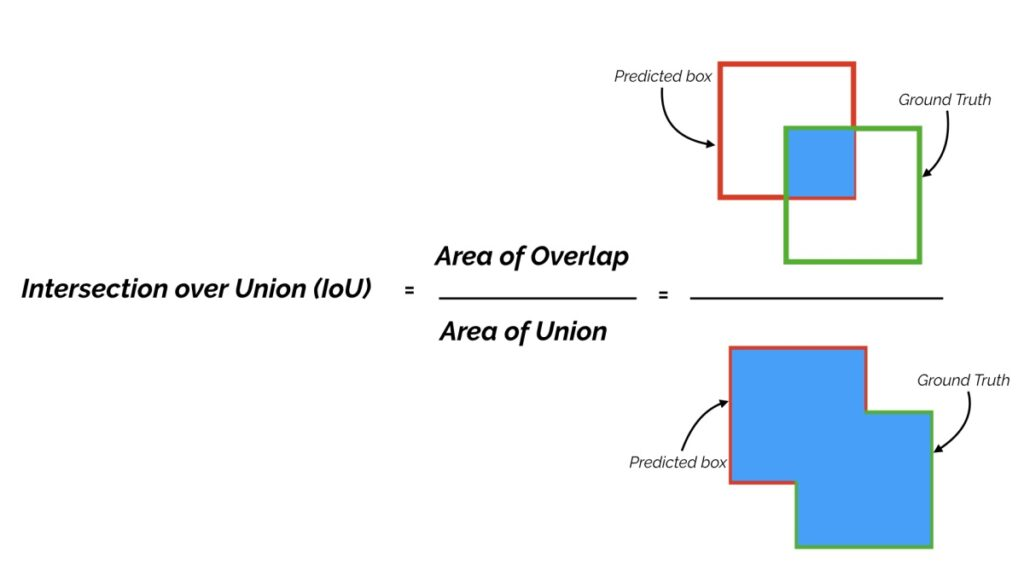

In [ ]:
import numpy as np

def compute_success_iou(BBtr, BBgt):
    if np.NaN in BBtr or np.NaN in BBgt:
        return 0
    # Compute Intersection over Union (IoU)
    x_tr, y_tr, w_tr, h_tr = BBtr
    x_gt, y_gt, w_gt, h_gt = BBgt

    x1_tr, y1_tr, x2_tr, y2_tr = x_tr, y_tr, x_tr + w_tr, y_tr + h_tr
    x1_gt, y1_gt, x2_gt, y2_gt = x_gt, y_gt, x_gt + w_gt, y_gt + h_gt

    intersection_w = min(x2_tr, x2_gt) - max(x1_tr, x1_gt)
    intersection_h = min(y2_tr, y2_gt) - max(y1_tr, y1_gt)
    intersection_area = max(0, intersection_w) * max(0, intersection_h)

    tr_area = w_tr * h_tr
    gt_area = w_gt * h_gt

    union_area = tr_area + gt_area - intersection_area
    IoU = intersection_area / union_area
    return IoU


def compute_precision(BBtr, BBgt, threshold=20):
    # Distance of ROI's centroids is within 20 pixels

    if np.NaN in BBtr or np.NaN in BBgt:
        return 0
    # Calculate centers of bounding boxes
    Ctr = np.array([(BBtr[0] + BBtr[2]) / 2, (BBtr[1] + BBtr[3]) / 2])
    Cgt = np.array([(BBgt[0] + BBgt[2]) / 2, (BBgt[1] + BBgt[3]) / 2])

    # Compute the distance between centers
    distance = np.linalg.norm(Ctr - Cgt)

    # Check if distance is within threshold
    if distance <= threshold:
        precision = 1  # Successful detection
    else:
        precision = 0  # Unsuccessful detection

    return precision


In [ ]:
def calculate_pr_npr_sc(ground_truth, tracker_ouput):
    columns = ['frame', 'track_id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'class_id', 'x', 'y', 'z']
    gt = pd.DataFrame(convert_to_desired_format(ground_truth), columns=columns)
    tr = pd.DataFrame(convert_to_desired_format(tracker_ouput), columns=columns)

    # Perform left join on frame and track_id
    joined_df = pd.merge(gt, tr, on=['frame', 'track_id'], how='left', suffixes=('_gt', '_tr'))

    # Apply compute_success_iou function to calculate IoU
    joined_df['IoU'] = joined_df.apply(lambda row: compute_success_iou(
        [row['bb_left_tr'], row['bb_top_tr'], row['bb_width_tr'], row['bb_height_tr']],
        [row['bb_left_gt'], row['bb_top_gt'], row['bb_width_gt'], row['bb_height_gt']]
    ), axis=1)

    # Apply compute_precision function to calculate precision
    joined_df['precision'] = joined_df.apply(lambda row: compute_precision(
        [row['bb_left_tr'], row['bb_top_tr'], row['bb_width_tr'], row['bb_height_tr']],
        [row['bb_left_gt'], row['bb_top_gt'], row['bb_width_gt'], row['bb_height_gt']]
    ), axis=1)

    joined_df.fillna(0, inplace=True)
    # Calculate average IoU and precision

    return joined_df.groupby('track_id')['IoU'].mean().reset_index()

In [ ]:
def generate_absolute_truth(vis_file, ir_file):
    # Read the tab-delimited text file into a pandas DataFrame
    df1 = pd.read_csv(vis_file, delimiter='\t', header=None, names=['frame_id','track_id', 'class', 'x', 'y', 'width', 'height'], dtype={'frame_id': int, 'track_id': int,'class': int, 'x': float, 'y': float, 'width': float, 'height': float}, on_bad_lines='skip')
    df2 =  pd.read_csv(ir_file, delimiter='\t', header=None, names=['frame_id', 'track_id','class', 'x', 'y', 'width', 'height'], dtype={'frame_id': int, 'track_id': int,'class': int, 'x': float, 'y': float, 'width': float, 'height': float}, on_bad_lines='skip')
    # Perform a full outer join on the two DataFrames
    merged_df = pd.merge(df1, df2, on=['frame_id', 'track_id'], how='outer', suffixes=('_vis', '_ir'))

    # Determine the bigger bounding box for each row and preserve only x, y, width, height
    merged_df['absolute_gt_x'] = merged_df.apply(lambda row: min(row['x_vis'], row['x_ir']) if not pd.isna(row['x_vis']) and not pd.isna(row['x_ir']) else row['x_vis'] if not pd.isna(row['x_vis']) else row['x_ir'], axis=1)
    merged_df['absolute_gt_y'] = merged_df.apply(lambda row: min(row['y_vis'], row['y_ir']) if not pd.isna(row['y_vis']) and not pd.isna(row['y_ir']) else row['y_vis'] if not pd.isna(row['y_vis']) else row['y_ir'], axis=1)
    merged_df['absolute_gt_width'] = merged_df.apply(lambda row: max(row['x_vis'] + row['width_vis'], row['x_ir'] + row['width_ir']) - min(row['x_vis'], row['x_ir']) if not pd.isna(row['x_vis']) and not pd.isna(row['x_ir']) else row['width_vis'] if not pd.isna(row['width_vis']) else row['width_ir'], axis=1)
    merged_df['absolute_gt_height'] = merged_df.apply(lambda row: max(row['y_vis'] + row['height_vis'], row['y_ir'] + row['height_ir']) - min(row['y_vis'], row['y_ir']) if not pd.isna(row['y_vis']) and not pd.isna(row['y_ir']) else row['height_vis'] if not pd.isna(row['height_vis']) else row['height_ir'], axis=1)

    merged_df['class_id'] = -1

    # Drop all other columns except frame_id, track_id, and absolute_gt
    merged_df = merged_df[['frame_id', 'track_id','class_id', 'absolute_gt_x', 'absolute_gt_y', 'absolute_gt_width', 'absolute_gt_height']]

    return merged_df

In [ ]:
def read_bbox_data_from_dataframe(dataframe):
    bbox_data = {}
    latest_frames = {}
    for index, row in dataframe.iterrows():
        frame = int(row['frame_id'])
        track_id = int(row['track_id'])
        class_id = int(row['class_id'])
        bbox = [int(row['absolute_gt_x']), int(row['absolute_gt_y']), int(row['absolute_gt_width']), int(row['absolute_gt_height'])]
        bbox_data.setdefault(frame, []).append((track_id, bbox))
        latest_frames[track_id] = max(frame, latest_frames.get(track_id, 0))  # Update the latest frame for the track_id
    return bbox_data, latest_frames

In [ ]:
def adjust_bounding_box(frame, roi):
    height, width, _ = frame.shape
    height -= 1
    width -= 1
    x, y, w, h = roi

    # Adjust x coordinate if it's less than 0
    if x < 0:
        w += x  # Decrease width
        x = 0   # Set x to 0

    # Adjust width if it exceeds the frame width
    if x + w > width:
        w = width - x

    # Adjust y coordinate if it's less than 0
    if y < 0:
        h += y  # Decrease height
        y = 0   # Set y to 0

    # Adjust height if it exceeds the frame height
    if y + h > height:
        h = height - y

    # Ensure width and height are at least 5
    w = max(5, w)
    h = max(5, h)

        # Adjust width if it exceeds the frame width
    if x + w > width:
        x = width - w

    # Adjust height if it exceeds the frame height
    if y + h > height:
        y = height - h


    return (x, y, w, h)

In [ ]:
def extract_image_features(frame, frame2, x, y, width, height):
    # frame is visible
    # frame2 is IR
    frame_copy = frame.copy()
    frame2_copy = frame2.copy()
    roi = frame_copy[y:y+height, x:x+width]
    roi2 = frame2_copy[y:y+height, x:x+width]

    frame_gray = cv2.cvtColor(frame_copy, cv2.COLOR_BGR2GRAY)
    frame2_gray = cv2.cvtColor(frame2_copy, cv2.COLOR_BGR2GRAY)
    roi_gray = frame_gray[y:y+height, x:x+width]
    roi2_gray = frame2_gray[y:y+height, x:x+width]

    rois = [(frame_gray, frame_copy),
            (frame2_gray, frame2_copy),
            (roi_gray, roi),
            (roi2_gray, roi2)]

    features = []

    for x in rois:
        gray_roi = x[0]
        roi = x[1]

        # Convert the cropped region to BGR
        b, g, r = cv2.split(roi)

        mean_intensity_b = np.mean(b)
        mean_intensity_g = np.mean(g)
        mean_intensity_r = np.mean(r)

        # Compute median intensity directly from pixel values
        median_intensity_b = np.median(b)
        median_intensity_g = np.median(g)
        median_intensity_r = np.median(r)

        # Compute mode intensity directly from pixel values
        mode_intensity_b = np.argmax(np.bincount(b.flatten()))
        mode_intensity_g = np.argmax(np.bincount(g.flatten()))
        mode_intensity_r = np.argmax(np.bincount(r.flatten()))

        # Compute standard deviation directly from pixel values
        std_deviation_b = np.std(b)
        std_deviation_g = np.std(g)
        std_deviation_r = np.std(r)

        # Compute intensity statistics
        mean_intensity = np.mean(gray_roi)
        variance_intensity = np.var(gray_roi)
        skewness_intensity = np.mean((gray_roi - mean_intensity) ** 3) / np.power(variance_intensity, 1.5)
        kurtosis_intensity = np.mean((gray_roi - mean_intensity) ** 4) / np.power(variance_intensity, 2) - 3

        area = width*height

        # Include all variables in the features list
        features += [mean_intensity_b, mean_intensity_g, mean_intensity_r,
                median_intensity_b, median_intensity_g, median_intensity_r,
                mode_intensity_b, mode_intensity_g, mode_intensity_r,
                std_deviation_b, std_deviation_g, std_deviation_r,
                mean_intensity, variance_intensity, skewness_intensity, kurtosis_intensity, area]

    # Return all features
    return features

In [ ]:
result = []
for y in ['frame_', 'roi_']:
    for x in ['_vis', '_ir']:
        for var in [
                'mean_intensity_b', 'mean_intensity_g', 'mean_intensity_r',
                'median_intensity_b', 'median_intensity_g', 'median_intensity_r',
                'mode_intensity_b', 'mode_intensity_g', 'mode_intensity_r',
                'std_deviation_b', 'std_deviation_g', 'std_deviation_r',
                'mean_intensity', 'variance_intensity', 'skewness_intensity', 'kurtosis_intensity', 'area']:
            result.append(y + var+x)


In [ ]:
def annotate(vid_in_vis, vid_in_ir, annotation_in_vis, annotation_in_ir):
    trackers = {}

    dt_data = pd.DataFrame(columns=['frame_number', 'track_id', 'x', 'y', 'w', 'h',
 'frame_mean_intensity_b_vis',
 'frame_mean_intensity_g_vis',
 'frame_mean_intensity_r_vis',
 'frame_median_intensity_b_vis',
 'frame_median_intensity_g_vis',
 'frame_median_intensity_r_vis',
 'frame_mode_intensity_b_vis',
 'frame_mode_intensity_g_vis',
 'frame_mode_intensity_r_vis',
 'frame_std_deviation_b_vis',
 'frame_std_deviation_g_vis',
 'frame_std_deviation_r_vis',
 'frame_mean_intensity_vis',
 'frame_variance_intensity_vis',
 'frame_skewness_intensity_vis',
 'frame_kurtosis_intensity_vis',
 'frame_area_vis',
 'frame_mean_intensity_b_ir',
 'frame_mean_intensity_g_ir',
 'frame_mean_intensity_r_ir',
 'frame_median_intensity_b_ir',
 'frame_median_intensity_g_ir',
 'frame_median_intensity_r_ir',
 'frame_mode_intensity_b_ir',
 'frame_mode_intensity_g_ir',
 'frame_mode_intensity_r_ir',
 'frame_std_deviation_b_ir',
 'frame_std_deviation_g_ir',
 'frame_std_deviation_r_ir',
 'frame_mean_intensity_ir',
 'frame_variance_intensity_ir',
 'frame_skewness_intensity_ir',
 'frame_kurtosis_intensity_ir',
 'frame_area_ir',
 'roi_mean_intensity_b_vis',
 'roi_mean_intensity_g_vis',
 'roi_mean_intensity_r_vis',
 'roi_median_intensity_b_vis',
 'roi_median_intensity_g_vis',
 'roi_median_intensity_r_vis',
 'roi_mode_intensity_b_vis',
 'roi_mode_intensity_g_vis',
 'roi_mode_intensity_r_vis',
 'roi_std_deviation_b_vis',
 'roi_std_deviation_g_vis',
 'roi_std_deviation_r_vis',
 'roi_mean_intensity_vis',
 'roi_variance_intensity_vis',
 'roi_skewness_intensity_vis',
 'roi_kurtosis_intensity_vis',
 'roi_area_vis',
 'roi_mean_intensity_b_ir',
 'roi_mean_intensity_g_ir',
 'roi_mean_intensity_r_ir',
 'roi_median_intensity_b_ir',
 'roi_median_intensity_g_ir',
 'roi_median_intensity_r_ir',
 'roi_mode_intensity_b_ir',
 'roi_mode_intensity_g_ir',
 'roi_mode_intensity_r_ir',
 'roi_std_deviation_b_ir',
 'roi_std_deviation_g_ir',
 'roi_std_deviation_r_ir',
 'roi_mean_intensity_ir',
 'roi_variance_intensity_ir',
 'roi_skewness_intensity_ir',
 'roi_kurtosis_intensity_ir',
 'roi_area_ir'])

    # Process frames and initialize trackers
    cap = cv2.VideoCapture(vid_in_vis)
    cap2 = cv2.VideoCapture(vid_in_ir)

    annotation_df = generate_absolute_truth(annotation_in_vis, annotation_in_ir)
    bbox_data, latest_frames = read_bbox_data_from_dataframe(annotation_df)

    while cap.isOpened() and cap2.isOpened():
        ret, frame = cap.read()
        ret2, frame2 = cap2.read()
        if not ret or not ret2:
            break

        frame_number = int(cap.get(cv2.CAP_PROP_POS_FRAMES))

        # Initialize trackers at the earliest frame where track_id appears
        if frame_number in bbox_data:
            for track_id, bbox in bbox_data[frame_number]:
                if track_id not in trackers:
                    image_shape = frame.shape
                    bbox = adjust_bounding_box(frame2, bbox)
                    trackers[track_id] = 1
                    x, y, w, h = bbox
                    features = extract_image_features(frame, frame2, x, y, w, h)

                    dt_data.loc[track_id] = [frame_number, track_id, x, y, w, h] + features

    # Release resources
    cap.release()
    cap2.release()
    cv2.destroyAllWindows()

    return dt_data

In [ ]:
from tqdm import tqdm

not_initiated = True

for i in tqdm(range(1, 31)):
    if i in [22,24,16,14,12]:
        continue

    dt = annotate(f'{path}/seq-{i}/Visual-seq{i}.mp4',
             f'{path}/seq-{i}/IR-seq{i}.mp4',
              f'{path}/seq-{i}/Seq{i}-Abs.txt',
             f'{path}/seq-{i}/Seq{i}-Abs.txt',)

    iou_vis = calculate_pr_npr_sc(f'{path}/seq-{i}/Seq{i}-Abs.txt', f'{path}/seq-{i}/{name}-Out_Seq{i}-Vis.txt')
    iou_ir = calculate_pr_npr_sc(f'{path}/seq-{i}/Seq{i}-Abs.txt', f'{path}/seq-{i}/{name}-Out_Seq{i}-IR.txt')

    result = dt.merge(iou_vis, on='track_id', suffixes=(None, '_vis'))
    result = result.merge(iou_ir, on='track_id', suffixes=(None, '_ir'))
    result['seq'] = i
    if not_initiated:
        final = result
        not_initiated= False
    else:
        final = pd.concat([final, result], ignore_index=True)


# Skipped Files Due to Missing Videos/Annotations

During the processing, the following files were skipped due to missing videos or annotations:

1. File 12
2. File 14
3. File 16
4. File 22
5. File 24

These files are excluded from the analysis as their corresponding videos or annotations are not available. Ensure you have the necessary files for these entries to continue with the analysis seamlessly.


In [ ]:
final

# Saving Extracted Features to "final.csv"

Let's wrap up this process by saving the extracted features to a CSV file named "final.csv". Here's how you can do it:

```python
import pandas as pd

# Assuming 'final' is your DataFrame containing the extracted features
final.to_csv(f'{path}/final.csv', header=True, index=False)



In [ ]:
final.to_csv(f'{path}/final.csv', header=True, index=False)